In [15]:

import pandas as pd
import matplotlib.pyplot as plt
from polyase import *
import anndata as ad
import numpy as np
import os

## 1) Loading the allele-specific count data 

First we load in the allele-specific counts for our 8 samples (IsoSeq from 4 x potato tubers, 4 x potato leaves). We also have some metadata that links the gene ids from the alleles of a gene together with "Synt_ids" and we have some information about the allele lengths that we use for quality control.

In [16]:
# Metadata for genes
var_obs_file = "/scratch/nadjafn/potato-allelic-orthogroups/output_atlantic/07_SYNTELOG_SIMILARITY/ATL_v3.hc_gene_models.repr_blast_syntelog_blast_analysis.tsv"
# directory of gene counts from minimap2
gene_counts_dir = "/scratch/nadjafn/Atlantic_ASE/polyploid-allele-exp/results/03_GENECOUNTS"
# Define sample IDs and their conditions
sample_info = {
    "SRR14993892": "leaf",
    "SRR14993893": "leaf", 
    "SRR14993894": "leaf",
    "SRR14993895": "leaf",
    "SRR14996168": "leaf",
    "SRR14995031": "tuber",
    "SRR14995032": "tuber",
    "SRR14995033": "tuber",
    "SRR14995034": "tuber",
    "SRR14995933": "tuber",
}

# Load the data into an AnnData object
allelic_data = load_ase_data(
    var_obs_file=var_obs_file,
    gene_counts_dir=gene_counts_dir,
    sample_info=sample_info, fillna=0)

### Task 1: look at the information of each transcript id and the grouping of alleles

In [17]:
allelic_data.var
#  remove the NaN rows

# rename Synt_id to gene_id

# more text to explain

Synt_id           synteny_category  \
transcript_id                                                          
Soltu.Atl_v3.06_2G013790.1            NaN                        NaN   
Soltu.Atl_v3.01_2G036600.1   Synt_id_6024  1hap1_1hap2_1hap3_1hap4_s   
Soltu.Atl_v3.09_0G013460.1            NaN                        NaN   
Soltu.Atl_v3.02_3G008660.1   Synt_id_6995  0hap1_0hap2_1hap3_1hap4_s   
Soltu.Atl_v3.04_4G019190.2  Synt_id_14369  1hap1_1hap2_1hap3_1hap4_s   
...                                   ...                        ...   
Soltu.Atl_v3.12_0G007550.1            NaN                        NaN   
Soltu.Atl_v3.09_0G014070.1            NaN                        NaN   
Soltu.Atl_v3.S159640.1                NaN                        NaN   
Soltu.Atl_v3.06_4G023260.2  Synt_id_19202  1hap1_1hap2_1hap3_1hap4_s   
Soltu.Atl_v3.02_1G024530.1   Synt_id_8566  1hap1_1hap2_0hap3_0hap4_s   

                           CDS_haplotype_with_longest_annotation  \
transcript_id                                                      
Soltu.Atl_v3.06_2G013790.1                                   NaN   
Soltu.Atl_v3.01_2G036600.1                                    1G   
Soltu.Atl_v3.09_0G013460.1                                   NaN   
Soltu.Atl_v3.02_3G008660.1                                   NaN   
Soltu.Atl_v3.04_4G019190.2                                    2G   
...                                                          ...   
Soltu.Atl_v3.12_0G007550.1                                   NaN   
Soltu.Atl_v3.09_0G014070.1                                   NaN   
Soltu.Atl_v3.S159640.1                                       NaN   
Soltu.Atl_v3.06_4G023260.2                         equal_lengths   
Soltu.Atl_v3.02_1G024530.1                                   NaN   

                            CDS_length_category mismatch_category  mismatch  
transcript_id                                                                
Soltu.Atl_v3.06_2G013790.1                  NaN               NaN       NaN  
Soltu.Atl_v3.01_2G036600.1  more_20%_difference               NaN       NaN  
Soltu.Atl_v3.09_0G013460.1                  NaN               NaN       NaN  
Soltu.Atl_v3.02_3G008660.1                  NaN               NaN       NaN  
Soltu.Atl_v3.04_4G019190.2   less_1%_difference               NaN       NaN  
...                                         ...               ...       ...  
Soltu.Atl_v3.12_0G007550.1                  NaN               NaN       NaN  
Soltu.Atl_v3.09_0G014070.1                  NaN               NaN       NaN  
Soltu.Atl_v3.S159640.1                      NaN               NaN       NaN  
Soltu.Atl_v3.06_4G023260.2   less_1%_difference              SNPs      26.0  
Soltu.Atl_v3.02_1G024530.1                  NaN               NaN       NaN  

[97433 rows x 6 columns]

In [18]:
allelic_data.layers['unique_counts']


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 1.]], shape=(10, 97433))

Data table rows are different genes

In [19]:
allelic_data.obs

condition
SRR14993892      leaf
SRR14993893      leaf
SRR14993894      leaf
SRR14993895      leaf
SRR14996168      leaf
SRR14995031     tuber
SRR14995032     tuber
SRR14995033     tuber
SRR14995034     tuber
SRR14995933     tuber

### Metadata
* Synt_id: links together the transcript ids from the same gene on the different haplotypes 
* synteny category: type of allele group (e.g 1hap1_1hap2_1hap3_1hap4_s: on each haplotype 1 copy of the gene)

# 2) Quality Control

We first need to check if the allelic counts are okay. 
We will also remove genes with low expression.

## Filter genenes with low expression

We filter Syntelog groups that don't have a min expression. This function can also be used to filter for gene_id expression or similar

In [32]:
allelic_data = filter_by_group_expression(
    allelic_data,
    min_expression=50.0,  # 20 count per million
    lib_size_normalization='cpm',
    mode='all',
    library_size_dependent=True,
    verbose=True)

# CPM threshold (automatically normalized)
# allelic_data = filter_low_expressed_genes(
#     allelic_data,
#     min_expression=20.0,  # 20 count per million
#     lib_size_normalization='cpm',
#     mode='all',
#     library_size_dependent=True,
#     verbose=True)
   

Using library-size adjusted thresholds:
  SRR14993892: 12.11
  SRR14993893: 6.38
  SRR14993894: 60.28
  SRR14993895: 29.87
  SRR14996168: 47.40
  ... and 5 more
Filtered out 0 groups
Kept 3413 / 3413 items


## Calculate allelic ratios

To see if there is bias 

In [33]:
allelic_data = calculate_allelic_ratios(allelic_data , 'unique_counts')
allelic_data = calculate_multi_ratios(allelic_data, 'unique_counts', 'ambiguous_counts')

In [34]:
allelic_data.layers['unique_counts'][0:10, 0:5]

array([[ 72.,   5.,  33.,   1.,   0.],
       [ 43.,   1.,  19.,   0.,   0.],
       [373.,  19., 193.,   0.,   0.],
       [206.,   6.,  93.,   0.,   0.],
       [355.,  11., 137.,   0.,   0.],
       [195.,  15.,  60.,   0.,   0.],
       [180.,   8.,  48.,   0.,   0.],
       [248.,  11.,  84.,   1.,   0.],
       [158.,   2.,  55.,   0.,   0.],
       [153.,   5.,  53.,   0.,   0.]])

In [24]:
allelic_data.layers["allelic_ratio_unique_counts"][0:10, 0:5]

array([[0.22929936, 0.03676471, 0.28947368, 0.00515464, 0.        ],
       [0.26708075, 0.01470588, 0.27536232, 0.        , 0.        ],
       [0.22911548, 0.03454545, 0.3088    , 0.        , 0.        ],
       [0.25183374, 0.02135231, 0.32291667, 0.        , 0.        ],
       [0.24652778, 0.03536977, 0.26968504, 0.        , 0.        ],
       [0.27698864, 0.04615385, 0.25531915, 0.        , 0.        ],
       [0.30201342, 0.04819277, 0.24489796, 0.        , 0.        ],
       [0.27802691, 0.044     , 0.29473684, 0.00653595, 0.        ],
       [0.29811321, 0.01290323, 0.3021978 , 0.        , 0.        ],
       [0.30417495, 0.0255102 , 0.27604167, 0.        , 0.        ]])

In [25]:
allelic_data.var.head()

# mulitmapping ratio = number of ambiguous counts / number of total (unique + ambiguous counts)

Synt_id              synteny_category  \
transcript_id                                                             
Soltu.Atl_v3.04_3G005900.1   Synt_id_1846  1hap1_1hap2_3hap3_1hap4_no_s   
Soltu.Atl_v3.06_2G012290.1  Synt_id_10191  1hap1_2hap2_1hap3_1hap4_no_s   
Soltu.Atl_v3.10_3G001680.1  Synt_id_26163     1hap1_1hap2_1hap3_1hap4_s   
Soltu.Atl_v3.03_4G019300.1  Synt_id_11647  1hap1_1hap2_1hap3_2hap4_no_s   
Soltu.Atl_v3.01_3G029840.1   Synt_id_5731     1hap1_1hap2_1hap3_1hap4_s   

                           CDS_haplotype_with_longest_annotation  \
transcript_id                                                      
Soltu.Atl_v3.04_3G005900.1                                   NaN   
Soltu.Atl_v3.06_2G012290.1                                   NaN   
Soltu.Atl_v3.10_3G001680.1                                    1G   
Soltu.Atl_v3.03_4G019300.1                                   NaN   
Soltu.Atl_v3.01_3G029840.1                                    2G   

                            CDS_length_category mismatch_category  mismatch  \
transcript_id                                                                 
Soltu.Atl_v3.04_3G005900.1                  NaN               NaN       NaN   
Soltu.Atl_v3.06_2G012290.1                  NaN               NaN       NaN   
Soltu.Atl_v3.10_3G001680.1  more_10%_difference               NaN       NaN   
Soltu.Atl_v3.03_4G019300.1                  NaN               NaN       NaN   
Soltu.Atl_v3.01_3G029840.1  more_10%_difference               NaN       NaN   

                            multimapping_ratio  
transcript_id                                   
Soltu.Atl_v3.04_3G005900.1            0.015955  
Soltu.Atl_v3.06_2G012290.1            0.555839  
Soltu.Atl_v3.10_3G001680.1            0.270709  
Soltu.Atl_v3.03_4G019300.1            0.042925  
Soltu.Atl_v3.01_3G029840.1            0.678792

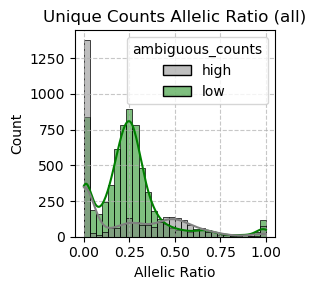

In [35]:
plot_allelic_ratios(
    allelic_data,
    synteny_category="1hap1_1hap2_1hap3_1hap4_s", 
    sample='all', 
    ratio_type="unique",
    figsize = (3,3),
    kde = True,
    multimapping_threshold=0.25
)

We observe that some genes have high bias towards one allele ('allelic_ratio_unique_counts' > 0.8). We can inspect these genes to see if there are any mistakes. In the next plot we will only look at genes that have the same CDS length for all allels

And genes with high bias should be gone. If there are still genes that have high allelic ratios and now mulitmapping reads we can extract them and analyze them in Jbrowse or similar 

In [36]:
high_bias = allelic_data[:,(allelic_data .var['multimapping_ratio'] < 0.25) & (allelic_data .layers['allelic_ratio_unique_counts'] > 0.6).all(axis=0) & (allelic_data .var["synteny_category"] == "1hap1_1hap2_1hap3_1hap4_s")]# & (test_ad.obsm["CDS_haplotype_with_longest_annotation"] == "equal_lengths") ]
high_bias.var.head()

Synt_id           synteny_category  \
transcript_id                                                          
Soltu.Atl_v3.02_4G016630.1   Synt_id_8100  1hap1_1hap2_1hap3_1hap4_s   
Soltu.Atl_v3.08_1G011030.1  Synt_id_22948  1hap1_1hap2_1hap3_1hap4_s   
Soltu.Atl_v3.07_3G020380.1  Synt_id_21422  1hap1_1hap2_1hap3_1hap4_s   
Soltu.Atl_v3.03_3G019960.1  Synt_id_10803  1hap1_1hap2_1hap3_1hap4_s   
Soltu.Atl_v3.02_1G001420.1   Synt_id_6413  1hap1_1hap2_1hap3_1hap4_s   

                           CDS_haplotype_with_longest_annotation  \
transcript_id                                                      
Soltu.Atl_v3.02_4G016630.1                                    1G   
Soltu.Atl_v3.08_1G011030.1                                    1G   
Soltu.Atl_v3.07_3G020380.1                                    1G   
Soltu.Atl_v3.03_3G019960.1                                    3G   
Soltu.Atl_v3.02_1G001420.1                                    3G   

                            CDS_length_category mismatch_category  mismatch  \
transcript_id                                                                 
Soltu.Atl_v3.02_4G016630.1  more_10%_difference               NaN       NaN   
Soltu.Atl_v3.08_1G011030.1  more_20%_difference               NaN       NaN   
Soltu.Atl_v3.07_3G020380.1  more_20%_difference               NaN       NaN   
Soltu.Atl_v3.03_3G019960.1  more_20%_difference               NaN       NaN   
Soltu.Atl_v3.02_1G001420.1  more_20%_difference               NaN       NaN   

                            multimapping_ratio  
transcript_id                                   
Soltu.Atl_v3.02_4G016630.1            0.012953  
Soltu.Atl_v3.08_1G011030.1            0.066812  
Soltu.Atl_v3.07_3G020380.1            0.006333  
Soltu.Atl_v3.03_3G019960.1            0.249174  
Soltu.Atl_v3.02_1G001420.1            0.034742

Now we want to look at one of these genes with high bias in more detail. First we look at the allelic ratios to see which of the alleles has the highest expression

In [37]:
# We will look at the allelic ratios
df = allelic_data[:,allelic_data .var["Synt_id"] == "Synt_id_12702"].layers['allelic_ratio_unique_counts']
pd.DataFrame(data= df, index = allelic_data[:,allelic_data .var["Synt_id"] == "Synt_id_12702"].obs.index, columns = allelic_data[:,allelic_data .var["Synt_id"] == "Synt_id_12702"].var_names)


transcript_id  Soltu.Atl_v3.04_4G002730.2  Soltu.Atl_v3.04_2G002760.1  \
SRR14993892                      0.089231                    0.076923   
SRR14993893                      0.141304                    0.070652   
SRR14993894                      0.081909                    0.094873   
SRR14993895                      0.108108                    0.076577   
SRR14996168                      0.079353                    0.079353   
SRR14995031                      0.091613                    0.080000   
SRR14995032                      0.065637                    0.048263   
SRR14995033                      0.071429                    0.061576   
SRR14995034                      0.134615                    0.053419   
SRR14995933                      0.075571                    0.056239   

transcript_id  Soltu.Atl_v3.04_3G002920.1  Soltu.Atl_v3.04_1G003230.1  
SRR14993892                      0.126154                    0.707692  
SRR14993893                      0.157609                    0.630435  
SRR14993894                      0.117855                    0.705362  
SRR14993895                      0.117117                    0.698198  
SRR14996168                      0.090909                    0.750385  
SRR14995031                      0.123871                    0.704516  
SRR14995032                      0.121622                    0.764479  
SRR14995033                      0.149015                    0.717980  
SRR14995034                      0.209402                    0.602564  
SRR14995933                      0.135325                    0.732865

The rows are the replicates and the columns are the alleic ratios for alleles

In [29]:
allelic_data[:,allelic_data .var["Synt_id"] == "Synt_id_12702"].var

Synt_id           synteny_category  \
transcript_id                                                          
Soltu.Atl_v3.04_4G002730.2  Synt_id_12702  1hap1_1hap2_1hap3_1hap4_s   
Soltu.Atl_v3.04_2G002760.1  Synt_id_12702  1hap1_1hap2_1hap3_1hap4_s   
Soltu.Atl_v3.04_3G002920.1  Synt_id_12702  1hap1_1hap2_1hap3_1hap4_s   
Soltu.Atl_v3.04_1G003230.1  Synt_id_12702  1hap1_1hap2_1hap3_1hap4_s   

                           CDS_haplotype_with_longest_annotation  \
transcript_id                                                      
Soltu.Atl_v3.04_4G002730.2                                    1G   
Soltu.Atl_v3.04_2G002760.1                                    1G   
Soltu.Atl_v3.04_3G002920.1                                    1G   
Soltu.Atl_v3.04_1G003230.1                                    1G   

                            CDS_length_category mismatch_category  mismatch  \
transcript_id                                                                 
Soltu.Atl_v3.04_4G002730.2  more_20%_difference               NaN       NaN   
Soltu.Atl_v3.04_2G002760.1  more_20%_difference               NaN       NaN   
Soltu.Atl_v3.04_3G002920.1  more_20%_difference               NaN       NaN   
Soltu.Atl_v3.04_1G003230.1  more_20%_difference               NaN       NaN   

                            multimapping_ratio  
transcript_id                                   
Soltu.Atl_v3.04_4G002730.2            0.032548  
Soltu.Atl_v3.04_2G002760.1            0.032548  
Soltu.Atl_v3.04_3G002920.1            0.032548  
Soltu.Atl_v3.04_1G003230.1            0.032548

Which of the alleles is the longest in the annotation? And which one with the highest allelic ratio?

Lets also look at the annotation in the [genome browser](https://spuddb.uga.edu/jb2/?session=share-Q7AqVFDKBg&password=OioEy) 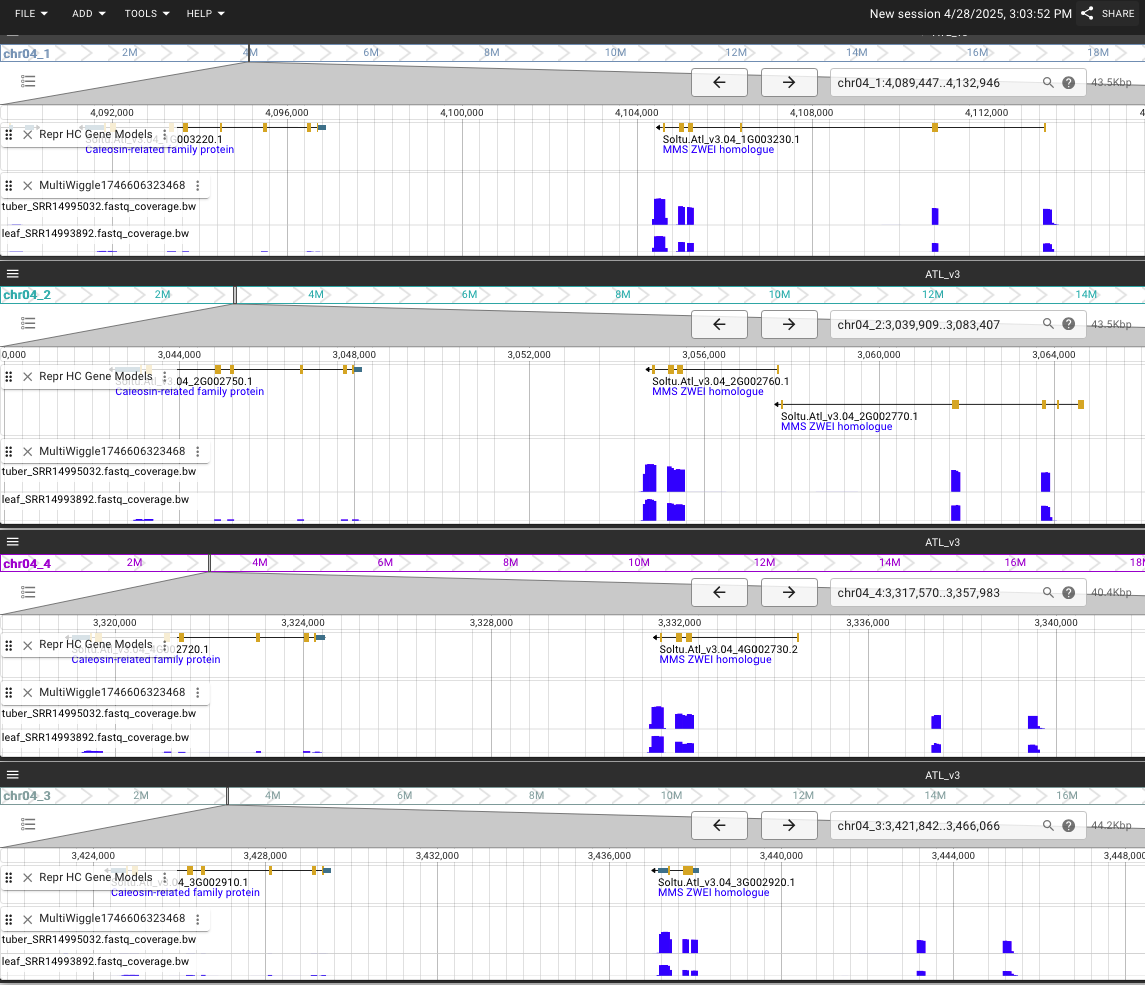

Should we compare the expression of these alleles?

## Alleles with same CDS length

To avoid annotation errors to bias the results, we will only look at alleles that have the same length on all haplotypes


https://spuddb.uga.edu/jb2/?session=share-XWreWcRKES&password=cAo2R

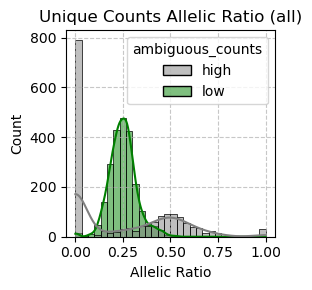

In [38]:
# filter transcripts that are not equal lengths
mask = allelic_data.var["CDS_haplotype_with_longest_annotation"] == "equal_lengths"
allelic_data_length_filter = allelic_data[:,mask].copy()
plot_allelic_ratios(
    allelic_data_length_filter,
    synteny_category="1hap1_1hap2_1hap3_1hap4_s", 
    sample='all', 
    ratio_type="unique",
    figsize = (3,3),
    kde = True,
    multimapping_threshold=0.25
)

# 3) Testing for allelic imbalance

Now that we have the count per allele and filtered genes that could be biased by high number of ambgious reads and length differences, we want to test if there are genens that have unbalanced allelic expression (> or < than 0.25).

The test is implemented as a likelihood ratio test, based on beta-binomial model of the observed read counts. It's the test from [Isotools](https://isotools.readthedocs.io/en/latest/notebooks/09_diff_splice.html)

In [40]:
def plot_top_differential_syntelogs(results_df, n=5, figsize=(3*6, 3), palette=None, jitter=0.2, alpha=0.7, ylim=(0, 1), sort_by='p_value', output_file=None, sig_threshold=0.05, difference_threshold=0.05, sig_color='red'):
    """
    Plot the top n syntelogs with differential allelic ratios in a grid layout (3 plots per row).
    Syntelogs with significant differences will have their titles highlighted in red.
    
    Parameters
    -----------
    results_df : pd.DataFrame
        Results dataframe from test_allelic_ratios function
    n : int, optional
        Number of top syntelogs to plot (default: 5)
    figsize : tuple, optional
        Figure size as (width, height) in inches (default: (16, 12))
    palette : dict or None, optional
        Color palette for conditions (default: None, uses seaborn defaults)
    jitter : float, optional
        Amount of jitter for strip plot (default: 0.2)
    alpha : float, optional
        Transparency of points (default: 0.7)
    ylim : tuple, optional
        Y-axis limits (default: (0, 1))
    sort_by : str, optional
        Column to sort results by ('p_value', 'FDR', or 'ratio_difference') (default: 'p_value')
    output_file : str, optional
        Path to save the figure (default: None, displays figure but doesn't save)
    sig_threshold : float, optional
        Significance threshold for p-value or FDR (default: 0.05)
    sig_color : str, optional
        Color for titles of syntelogs with significant differences (default: 'red')
        
    Returns
    --------
    fig : matplotlib.figure.Figure
        The generated figure
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np
    import math
    
    if len(results_df) == 0:
        print("No results to plot")
        return None
    
    # Validate sort_by parameter
    if sort_by not in ['p_value', 'FDR', 'ratio_difference']:
        print(f"Invalid sort_by parameter '{sort_by}'. Using 'p_value' instead.")
        sort_by = 'p_value'
    
    # Ensure FDR column exists
    if 'FDR' not in results_df.columns and sort_by == 'FDR':
        print("FDR column not found. Using p_value for sorting.")
        sort_by = 'p_value'
    
    # Ensure ratio_difference column exists
    if 'ratio_difference' not in results_df.columns and sort_by == 'ratio_difference':
        print("ratio_difference column not found. Using p_value for sorting.")
        sort_by = 'p_value'
    
    if sort_by == 'ratio_difference':
        ascending_bool = False
    else:
        ascending_bool = True

    # Get the condition names
    condition_columns = [col for col in results_df.columns if col.startswith('ratios_rep_')]
    if not condition_columns:
        print("No ratio columns found in dataframe")
        return None
    
    conditions = [col.replace('ratios_rep_', '') for col in condition_columns]
    
    # Get top n syntelogs with lowest sort_by values
    top_syntelogs = results_df.sort_values(sort_by, ascending=ascending_bool).drop_duplicates('Synt_id').head(n)['Synt_id'].unique()
    
    # Filter results to include only these syntelogs
    top_results = results_df[results_df['Synt_id'].isin(top_syntelogs)]
    
    # Calculate grid dimensions - 3 plots per row
    cols = 6
    rows = math.ceil(len(top_syntelogs) / cols)
    
    # Create the figure with grid layout
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    # Convert axes to flattened array for easier indexing
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    elif rows == 1 or cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()

    # Plot each syntelog
    for i, synt_id in enumerate(top_syntelogs):
        # Get data for this syntelog
        synt_data = top_results[top_results['Synt_id'] == synt_id].copy()
        
        # Sort by allele for better visualization
        synt_data = synt_data.sort_values('allele')
    
        # Get stats for this syntelog (take first row since they're the same for all replicates)
        p_value = synt_data['p_value'].min()
        fdr = synt_data['FDR'].min() if 'FDR' in synt_data.columns else np.nan
        ratio_difference = synt_data['ratio_difference'].max() if 'ratio_difference' in synt_data.columns else np.nan
        n_alleles = synt_data['n_alleles'].iloc[0]

        # Explode the replicate ratio columns
        explode_cols = [col for col in synt_data.columns if col.startswith('ratios_rep_')]
        synt_data_exploded = synt_data.explode(explode_cols)

        # Reshape data for seaborn
        synt_data_melted = pd.melt(
            synt_data_exploded, 
            id_vars=['Synt_id', 'allele', 'transcript_id', 'FDR'] if 'FDR' in synt_data.columns else ['Synt_id', 'allele', 'transcript_id'], 
            value_vars=condition_columns,
            var_name='condition', 
            value_name='ratio'
        )
        
        # Clean up condition names
        synt_data_melted['condition'] = synt_data_melted['condition'].str.replace('ratios_rep_', '')

        # Create the stripplot
        ax = axes[i]
        sns.stripplot(
            x='allele', 
            y='ratio', 
            hue='condition',
            data=synt_data_melted, 
            jitter=jitter, 
            alpha=alpha,
            palette=palette,
            ax=ax
        )
        # get the asterisks for the FDRs
        pvalue_asterisks = [convert_pvalue_to_asterisks(x) for x in synt_data['FDR']]
  
        # Add mean values as horizontal lines for each allele and condition
        i = 0
        for allele in synt_data['allele'].unique():
            allele_pos = list(synt_data['allele'].unique()).index(allele)
            #ax.text(x=allele_pos-0.1 , y=0.9, s=pvalue_asterisks[i])
            i = i+1
            for j, cond in enumerate(conditions):
                mean_col = f'ratios_{cond}_mean'
                if mean_col in synt_data.columns:
                    mean_val = synt_data[synt_data['allele'] == allele][mean_col].iloc[0]
                    allele_pos = list(synt_data['allele'].unique()).index(allele)
                    ax.hlines(
                        y=mean_val, 
                        xmin=allele_pos-0.2, 
                        xmax=allele_pos+0.2, 
                        colors=ax.get_legend().get_lines()[j].get_color(),
                        linewidth=2
                    )
        
        # Set title and labels
        fdr_text = f", FDR = {fdr:.2e}" if not np.isnan(fdr) else ""
        p_value_text = f", p = {p_value:.2e}"
        
        # Determine if this syntelog has a significant difference
        is_significant = False
        if 'FDR' in synt_data.columns and not np.isnan(fdr):
            is_significant = (fdr <= sig_threshold) & (ratio_difference > difference_threshold)
        else:
            is_significant = p_value <= sig_threshold
        
        # Set title color based on significance
        title_color = sig_color if is_significant else 'black'
        
        # Add title with optional stats and color based on significance
        ax.set_title(f"{synt_id}{fdr_text}", color=title_color)
        ax.set_xlabel('Allele')
        ax.set_ylabel('Expression Ratio')
        
        # Set y-limits
        ax.set_ylim(ylim)
        
        # Adjust legend
        ax.legend(title='Condition', loc='best')
    
    # Hide unused subplots if any
    for j in range(len(top_syntelogs), rows * cols):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    
    # Save figure if requested
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
    
    return fig

# Note: The convert_pvalue_to_asterisks function was referenced but not defined in the original code.
# If needed, you would define it like this:
def convert_pvalue_to_asterisks(pvalue):
    """Convert p-values to significance asterisks notation."""
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    else:
        return ""

Found 9 from 57 syntelogs with at least one significantly different allele (FDR < 0.05 and ratio difference > 0.1)


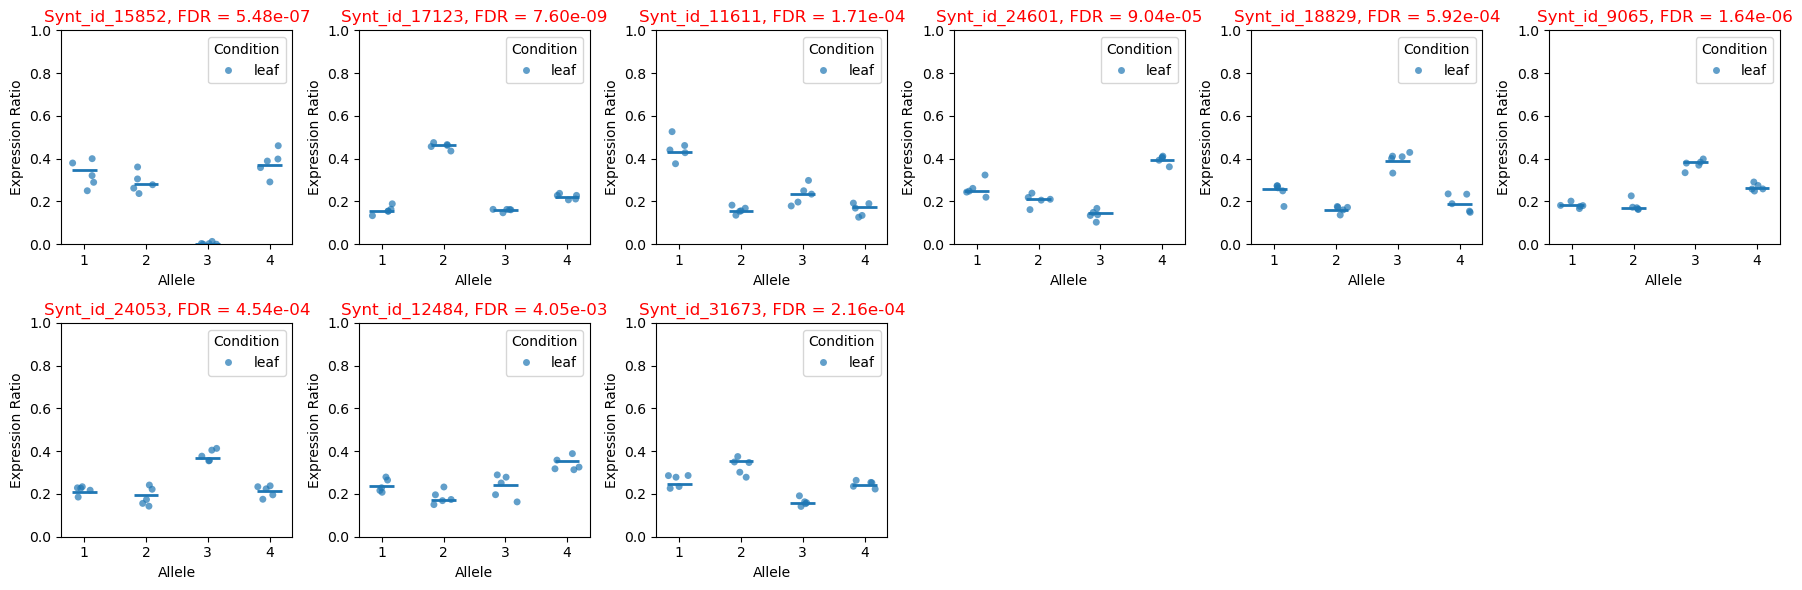

In [41]:
# select only the genes with equal lengths, low multimapping ratio and synteny category "1hap1_1hap2_1hap3_1hap4_s"
mask = (allelic_data.var["CDS_haplotype_with_longest_annotation"] == "equal_lengths" ) & (allelic_data.var["multimapping_ratio"] < 0.25) & (allelic_data.var["synteny_category"] == "1hap1_1hap2_1hap3_1hap4_s")
allelic_data_length_filter = allelic_data[:,mask].copy()

# 1. Test for differential allelic ratios withing conditions
results = test_allelic_ratios_within_conditions(allelic_data_length_filter, layer="unique_counts", test_condition= "leaf", inplace=True)

# 2. Get top differential syntelogs
top_results = get_top_differential_syntelogs(results, n=10, sort_by='FDR', fdr_threshold=0.005, ratio_threshold=0.1)

# 3. Plot the results
fig = plot_top_differential_syntelogs(top_results, n = 10, figsize = (3*6, 6),sort_by='ratio_difference')
plt.show()

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib as mpl

def create_blue_white_red_cmap(name='blue_white_red', white_range=(0.2, 0.3)):
    """
    Create a custom colormap with blue for low values, white in the middle range,
    and red for high values.
    
    Parameters:
    -----------
    name : str
        Name of the colormap
    white_range : tuple
        Range of values (from 0 to 1) where the color should be white
        
    Returns:
    --------
    cmap : LinearSegmentedColormap
        The custom colormap
    """
    # Ensure white_range values are between 0 and 1
    lower_white = max(0, min(1, white_range[0]))
    upper_white = max(0, min(1, white_range[1]))
    
    # Create color segments
    # From 0 to lower_white: blue to white
    # From lower_white to upper_white: white
    # From upper_white to 1: white to red
    
    # Define the colors at specific positions
    colors = [
        (0.0, (0.0, 0.0, 0.8)),      # Dark blue at 0.0
        (lower_white, (1.0, 1.0, 1.0)),  # White at lower_white
        (upper_white, (1.0, 1.0, 1.0)),  # White at upper_white
        (1.0, (0.8, 0.0, 0.0))       # Dark red at 1.0
    ]
    
    # Create the colormap
    cmap = LinearSegmentedColormap.from_list(name, colors)
    
    return cmap


In [121]:
my_cmap = create_blue_white_red_cmap(name='blue_white_red', white_range=(0.22, 0.27))

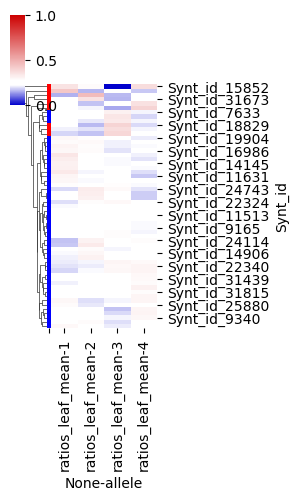

In [133]:
import seaborn as sns
results["significant"] = (results["FDR"] < 0.05) & (results["ratio_difference"] > 0.1)
glue = results.pivot(index="Synt_id", columns="allele", values=["ratios_leaf_mean"])
sig = results.pivot(index="Synt_id", columns="allele", values=["significant"]).mean(axis=1)
sig["significant"] = sig > 0
row_colors = sig["significant"].map({True: "red", False: "blue"})

# ,
sns.clustermap(glue, cmap=my_cmap, col_cluster= False, row_cluster= True, row_colors=row_colors, figsize=(3, 5
                                                                                                          ), vmin = 0, vmax = 1)



In [80]:
sig["significant"]

Synt_id
Synt_id_11342    False
Synt_id_11354    False
Synt_id_11513    False
Synt_id_11611     True
Synt_id_11631    False
Synt_id_12451    False
Synt_id_12484     True
Synt_id_12517    False
Synt_id_13972    False
Synt_id_14145    False
Synt_id_14906    False
Synt_id_15852     True
Synt_id_15913    False
Synt_id_16428    False
Synt_id_16986    False
Synt_id_16998    False
Synt_id_17105    False
Synt_id_17123     True
Synt_id_17971    False
Synt_id_18640    False
Synt_id_18829     True
Synt_id_18831    False
Synt_id_19591    False
Synt_id_19904    False
Synt_id_20878    False
Synt_id_21364    False
Synt_id_22324    False
Synt_id_22340    False
Synt_id_24053     True
Synt_id_24114    False
Synt_id_24601     True
Synt_id_24743    False
Synt_id_25421    False
Synt_id_25880    False
Synt_id_27737    False
Synt_id_29272    False
Synt_id_29294    False
Synt_id_29299    False
Synt_id_29514    False
Synt_id_30459    False
Synt_id_31439    False
Synt_id_31673     True
Synt_id_31815    False
Syn

ratios_leaf_mean                               significant  \
allele                       1         2         3         4           1   
Synt_id                                                                    
Synt_id_11342         0.301997  0.278525  0.209214  0.216161       False   
Synt_id_11354         0.322963  0.264475  0.216822  0.196019       False   
Synt_id_11513          0.25179  0.267536  0.238545  0.240402       False   
Synt_id_11611         0.432097  0.156712  0.236293   0.17383        True   
Synt_id_11631         0.300134  0.256055  0.271672  0.172303       False   
Synt_id_12451         0.341913  0.230521  0.220067  0.209046       False   
Synt_id_12484         0.234952  0.171737  0.239548  0.355588       False   
Synt_id_12517          0.29538  0.216674   0.26595  0.221715       False   
Synt_id_13972         0.274443  0.236671  0.274059  0.214937       False   
Synt_id_14145         0.312327  0.241424  0.217822  0.230499       False   
Synt_id_14906         0.215911   0.29436  0.245514  0.244145       False   
Synt_id_15852         0.348336  0.282893  0.003139  0.368961       False   
Synt_id_15913         0.229928  0.285102  0.214068  0.264012       False   
Synt_id_16428         0.262292   0.24878  0.169471  0.297124       False   
Synt_id_16986         0.294515  0.281996  0.197246  0.226438       False   
Synt_id_16998          0.20379  0.212102  0.297414  0.287464       False   
Synt_id_17105         0.239909  0.266375  0.191227  0.302597       False   
Synt_id_17123         0.156109  0.462873  0.161335  0.219763       False   
Synt_id_17971         0.240883  0.316627   0.25867  0.178236       False   
Synt_id_18640         0.260009  0.227571  0.221958  0.290531       False   
Synt_id_18829         0.260443  0.161655  0.390835  0.189767       False   
Synt_id_18831         0.265706  0.282131  0.193536  0.258949       False   
Synt_id_19591         0.248276  0.226996  0.339882  0.185234       False   
Synt_id_19904         0.290551  0.274376  0.232692  0.206656       False   
Synt_id_20878         0.207843  0.260075  0.249189  0.282292       False   
Synt_id_21364         0.247477  0.310209  0.264771  0.176419       False   
Synt_id_22324         0.191929  0.278141  0.291107  0.240423       False   
Synt_id_22340         0.198434  0.203191  0.292144  0.304379       False   
Synt_id_24053         0.210846  0.196724  0.368847  0.213895       False   
Synt_id_24114         0.170452  0.307268  0.240931   0.28064       False   
Synt_id_24601         0.246677  0.213132   0.14808  0.392195       False   
Synt_id_24743         0.190126  0.326294  0.285487   0.19843       False   
Synt_id_25421         0.293282   0.19273  0.214269  0.299591       False   
Synt_id_25880         0.284401   0.20224   0.25092  0.262667       False   
Synt_id_27737         0.246982  0.262152  0.277446  0.213809       False   
Synt_id_29272         0.185779  0.215365  0.296316  0.302347       False   
Synt_id_29294         0.250072  0.202223  0.335756  0.212719       False   
Synt_id_29299         0.207233   0.30519  0.228424  0.260933       False   
Synt_id_29514         0.174265  0.328622  0.227289  0.269074       False   
Synt_id_30459         0.334675  0.211269   0.26042  0.193715       False   
Synt_id_31439         0.245885  0.242345  0.231145  0.288662       False   
Synt_id_31673         0.246633  0.354184  0.157038  0.243182       False   
Synt_id_31815         0.230607  0.229186  0.261659  0.279536       False   
Synt_id_5653          0.260067  0.265669  0.257766    0.2163       False   
Synt_id_5776          0.248091  0.245473  0.244358  0.257048       False   
Synt_id_6998          0.312938  0.260345  0.227586  0.216561       False   
Synt_id_7011          0.247137  0.262539  0.243957  0.246498       False   
Synt_id_7633           0.23093   0.24049  0.312317  0.214069       False   
Synt_id_8124          0.281862  0.285335  0.208992  0.223034       False   
Synt_id_9065          0.184767  0.169114  0.383564  0.261812  

In [46]:
glue 

Task         CoLA  MNLI  MRPC  QNLI   QQP   RTE  SST-2  STS-B
Model                                                        
BERT         60.5  86.7  89.3  92.7  72.1  70.1   94.9   87.6
BiLSTM       11.6  65.6  81.8  74.6  62.5  57.4   82.8   70.3
BiLSTM+Attn  18.6  67.6  83.9  74.3  60.1  58.4   83.0   72.8
BiLSTM+CoVe  18.5  65.4  78.7  70.8  60.6  52.7   81.9   64.4
BiLSTM+ELMo  32.1  67.2  84.7  75.5  61.1  57.4   89.3   70.3
ERNIE        75.5  92.3  93.9  97.3  75.2  92.6   97.8   93.0
RoBERTa      67.8  90.8  92.3  95.4  74.3  88.2   96.7   92.2
T5           71.6  92.2  92.8  96.9  75.1  92.8   97.5   93.1

In [ ]:
df = allelic_data[:,allelic_data .var["Synt_id"] == "Synt_id_17123"].layers['unique_counts']
pd.DataFrame(data= df, index = allelic_data[:,allelic_data .var["Synt_id"] == "Synt_id_17123"].obs.index, columns = allelic_data[:,allelic_data .var["Synt_id"] == "Synt_id_17123"].var_names)

transcript_id  Soltu.Atl_v3.06_4G000620.1  Soltu.Atl_v3.06_3G000610.3  \
SRR14993892                         171.0                       117.0   
SRR14993893                          87.0                        56.0   
SRR14993894                         785.0                       554.0   
SRR14993895                         359.0                       277.0   
SRR14996168                         511.0                       400.0   
SRR14995031                         144.0                        98.0   
SRR14995032                          92.0                        86.0   
SRR14995033                         155.0                        88.0   
SRR14995034                          89.0                        57.0   
SRR14995933                          89.0                        57.0   

transcript_id  Soltu.Atl_v3.06_1G000450.1  Soltu.Atl_v3.06_2G000620.2  
SRR14993892                          96.0                       335.0  
SRR14993893                          72.0                       166.0  
SRR14993894                         531.0                      1572.0  
SRR14993895                         278.0                       785.0  
SRR14996168                         382.0                      1171.0  
SRR14995031                          95.0                       274.0  
SRR14995032                          74.0                       210.0  
SRR14995033                          98.0                       315.0  
SRR14995034                          66.0                       178.0  
SRR14995933                          49.0                       198.0

### Lets look at the gene with "Synt_id_17123" in more detail:

In [ ]:
results[results["Synt_id"] == "Synt_id_17123"]

Synt_id allele               transcript_id       p_value  \
311  Synt_id_17123      2  Soltu.Atl_v3.06_2G000620.2  3.332783e-11   
309  Synt_id_17123      3  Soltu.Atl_v3.06_3G000610.3  7.212484e-09   
310  Synt_id_17123      1  Soltu.Atl_v3.06_1G000450.1  8.571664e-08   
308  Synt_id_17123      4  Soltu.Atl_v3.06_4G000620.1  1.950837e-03   

     ratio_difference  n_alleles  ratios_leaf_mean  \
311          0.212934          4          0.462873   
309          0.088604          4          0.161335   
310          0.093830          4          0.156109   
308          0.030176          4          0.219763   

                                       ratios_rep_leaf           FDR  
311  [0.4659248956884562, 0.4356955380577428, 0.456...  2.892856e-08  
309  [0.1627260083449235, 0.14698162729658792, 0.16...  1.043406e-06  
310  [0.13351877607788595, 0.1889763779527559, 0.15...  7.637232e-06  
308  [0.23783031988873435, 0.2283464566929134, 0.22...  1.273178e-02

In [ ]:
results[results["Synt_id"] == "Synt_id_11611"]

Synt_id allele               transcript_id   p_value  \
11  Synt_id_11611      1  Soltu.Atl_v3.03_1G022650.1  0.000010   
9   Synt_id_11611      2  Soltu.Atl_v3.03_2G020270.1  0.000216   
10  Synt_id_11611      4  Soltu.Atl_v3.03_4G018940.1  0.000771   
8   Synt_id_11611      3  Soltu.Atl_v3.03_3G028240.1  0.380760   

    ratio_difference  n_alleles  ratios_leaf_mean  \
11          0.181527          4          0.432097   
9           0.093857          4          0.156712   
10          0.076740          4          0.173830   
8           0.014277          4          0.236293   

                                      ratios_rep_leaf       FDR  
11  [0.5263157894736842, 0.46153846153846156, 0.44...  0.000123  
9   [0.16842105263157894, 0.15384615384615385, 0.1...  0.001136  
10  [0.12631578947368421, 0.1346153846153846, 0.16...  0.003350  
8   [0.17894736842105263, 0.25, 0.2342569269521410...  0.522835

Lets look at the expression for these alleles in the genome Browser https://spuddb.uga.edu/jb2/?session=share-y51Gk46x4-&password=RWDWO

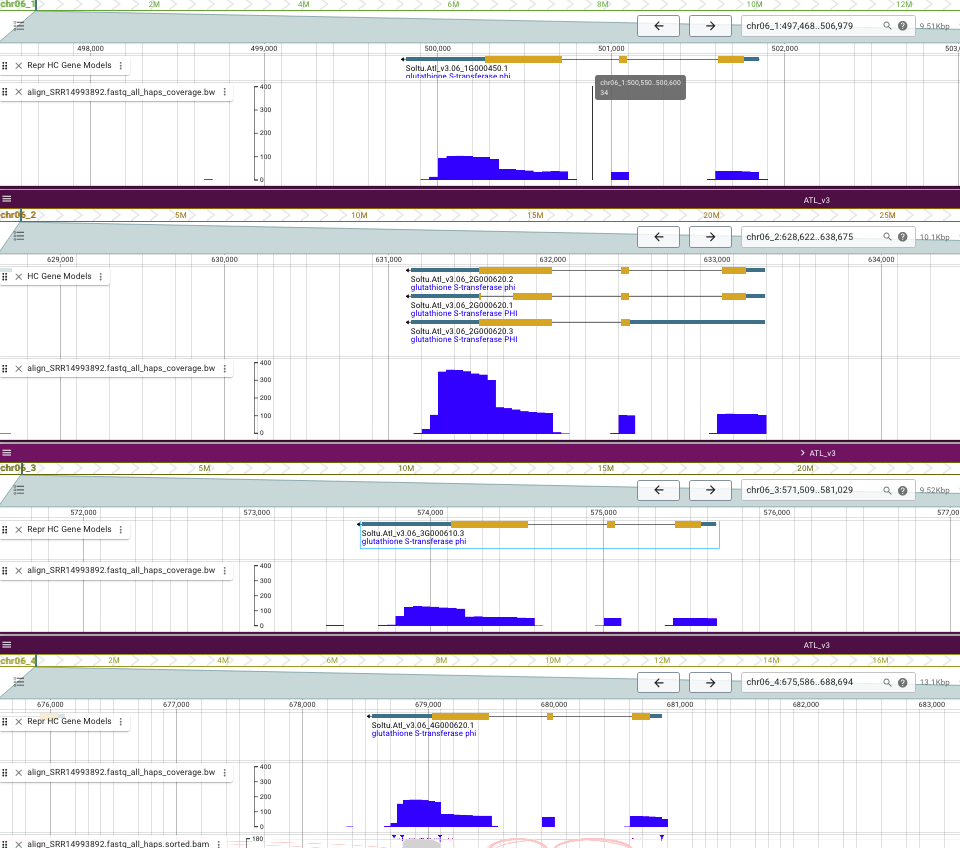

Why is the allele 2 of gluthadione S-transferase hihger expressed than the other alleles?

## Cis reulatory element? Promotor analysis?

We look at the promotor region (500 bp upstream of the CDS start)

[digaling](https://www.genome.jp/digalign/u/5eZ13FJaq_zJA1wC7Q7ORA/aln/chr06_1_501767-502776/chr06_2_633175-634170/chr06_3_575575-576598/chr06_4_680760-681844/chr06_1_501767-502776/chr06_3_575575-576598?autopos_flag=off&show_labels=on&label_angle=0&gene_tooltip=on&percent_thre_mode=default&percent_thre_customize=&blast_tooltip=on&color_mode=default&color_mode_customize=&vertical=off&show_ticks=on&show_dashed_lines=on&blast_idt_thre=0&blast_scr_thre=0&blast_len_thre=0&scale=5&v_span=160&tick_span=0.5&grid_span=1&fontfamily=Times%20new%20roman&fontsize=14&fontweight=bold&cutpos1=0&offset1=0&strand1=forward&cutpos2=0&offset2=0&strand2=forward&cutpos3=0&offset3=0&strand3=forward&cutpos4=0&offset4=0&strand4=forward&cutpos5=0&offset5=0&strand5=forward&cutpos6=0&offset6=0&strand6=forward)

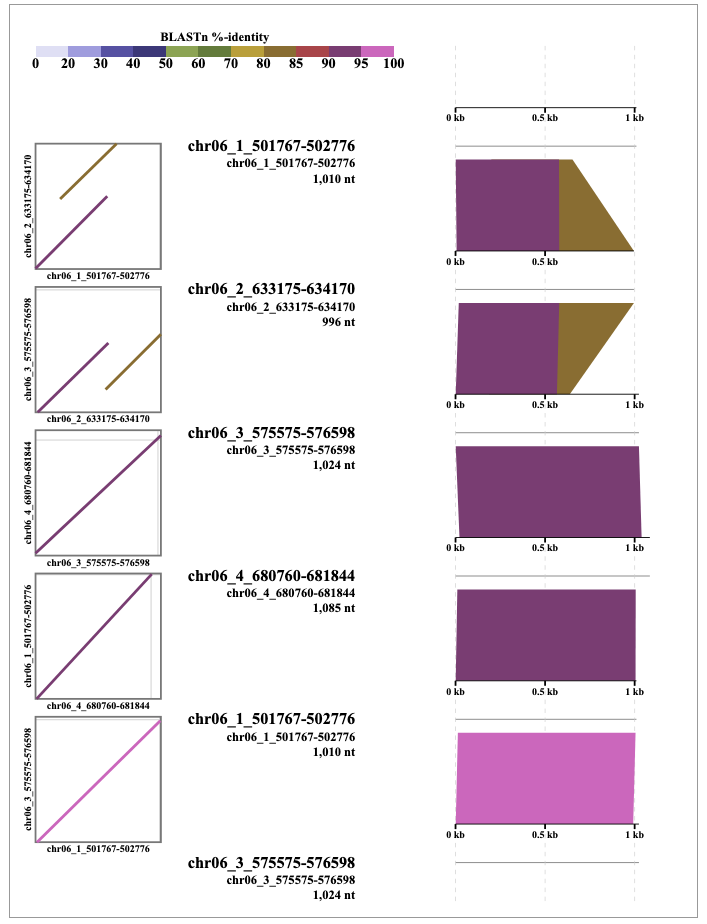

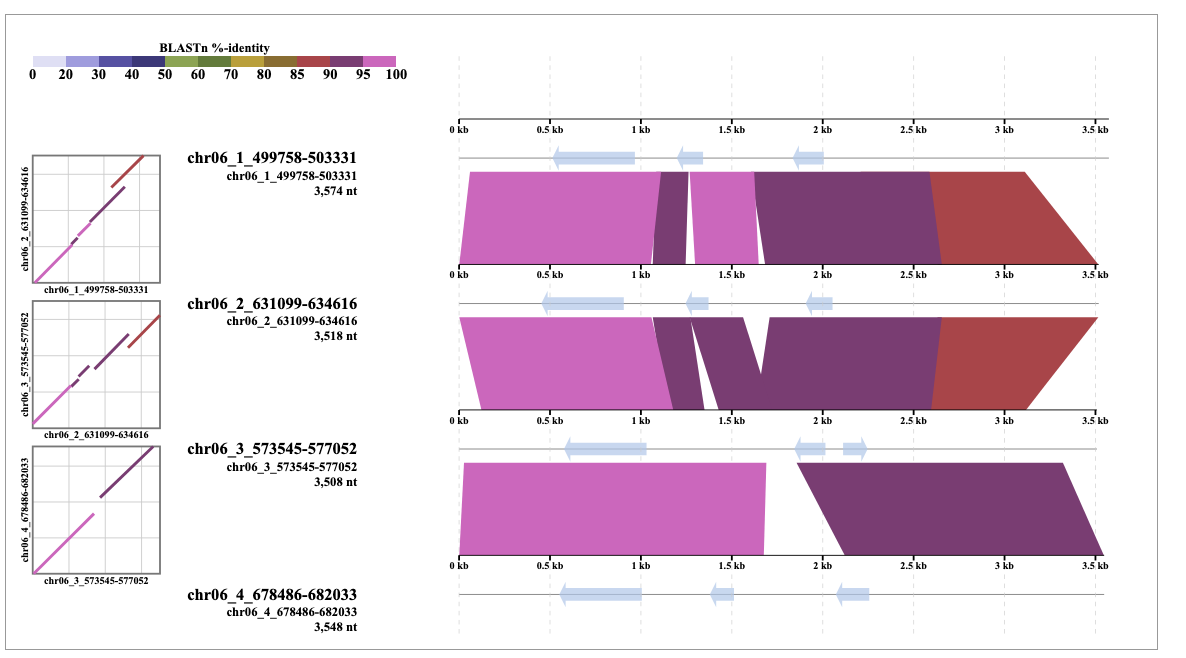

https://www.genome.jp/digalign/u/53kR88J_Pi7hkta3z3hB_w/aln/chr06_1_499758-503331/chr06_2_631099-634616/chr06_3_573545-577052/chr06_4_678486-682033


### We also want to look at the genes with no difference in expession

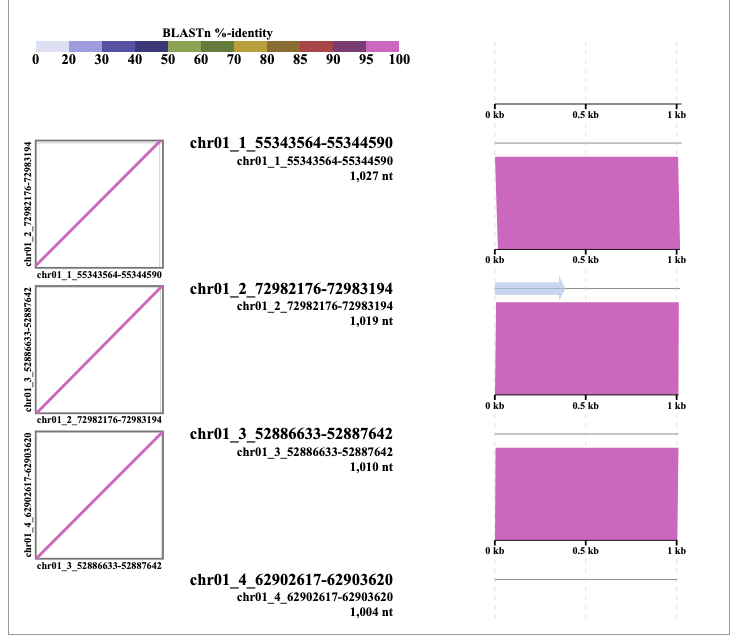

In [ ]:
results.groupby('Synt_id').max("ratio_difference").sort_values(by='ratio_difference', ascending= True).head(20)
results[results["Synt_id"] == "Synt_id_5776"]

Synt_id allele               transcript_id   p_value  \
143  Synt_id_5776      4  Soltu.Atl_v3.01_4G032390.1  0.078812   
142  Synt_id_5776      1  Soltu.Atl_v3.01_1G028730.1  0.173778   
141  Synt_id_5776      2  Soltu.Atl_v3.01_2G034660.1  0.915240   
140  Synt_id_5776      3  Soltu.Atl_v3.01_3G030290.1  0.982268   

     ratio_difference  n_alleles  ratios_all_mean  \
143          0.016761          4         0.266617   
142          0.013476          4         0.236380   
141          0.003716          4         0.246140   
140          0.000521          4         0.250377   

                                        ratios_rep_all       FDR  
143  [0.23348017621145375, 0.225, 0.288706058339566...  0.099325  
142  [0.2775330396475771, 0.25, 0.23784592370979807...  0.202374  
141  [0.22466960352422907, 0.24166666666666667, 0.2...  0.951436  
140  [0.2643171806167401, 0.2833333333333333, 0.231...  1.000000

In [ ]:
#results.groupby('Synt_id').max("ratio_difference").sort_values(by='ratio_difference', ascending= True).head(20)

df = allelic_data[:,allelic_data .var["Synt_id"] == "Synt_id_15852"].layers['unique_counts']
#print(pd.DataFrame(data= df, index = allelic_data[:,allelic_data .var["Synt_id"] == "Synt_id_15852"].obs.index, columns = allelic_data[:,allelic_data .var["Synt_id"] == "Synt_id_15852"].var_names))
allelic_data[:,allelic_data .var["Synt_id"] == "Synt_id_15852"].var

Synt_id           synteny_category  \
transcript_id                                                          
Soltu.Atl_v3.05_2G010680.1  Synt_id_15852  1hap1_1hap2_1hap3_1hap4_s   
Soltu.Atl_v3.05_1G011160.1  Synt_id_15852  1hap1_1hap2_1hap3_1hap4_s   
Soltu.Atl_v3.05_3G010830.1  Synt_id_15852  1hap1_1hap2_1hap3_1hap4_s   
Soltu.Atl_v3.05_4G008850.1  Synt_id_15852  1hap1_1hap2_1hap3_1hap4_s   

                           CDS_haplotype_with_longest_annotation  \
transcript_id                                                      
Soltu.Atl_v3.05_2G010680.1                         equal_lengths   
Soltu.Atl_v3.05_1G011160.1                         equal_lengths   
Soltu.Atl_v3.05_3G010830.1                         equal_lengths   
Soltu.Atl_v3.05_4G008850.1                         equal_lengths   

                           CDS_length_category mismatch_category  mismatch  \
transcript_id                                                                
Soltu.Atl_v3.05_2G010680.1  less_1%_difference              SNPs      13.0   
Soltu.Atl_v3.05_1G011160.1  less_1%_difference              SNPs      13.0   
Soltu.Atl_v3.05_3G010830.1  less_1%_difference              SNPs      13.0   
Soltu.Atl_v3.05_4G008850.1  less_1%_difference              SNPs      13.0   

                            multimapping_ratio  
transcript_id                                   
Soltu.Atl_v3.05_2G010680.1            0.140301  
Soltu.Atl_v3.05_1G011160.1            0.140301  
Soltu.Atl_v3.05_3G010830.1            0.140301  
Soltu.Atl_v3.05_4G008850.1            0.140301

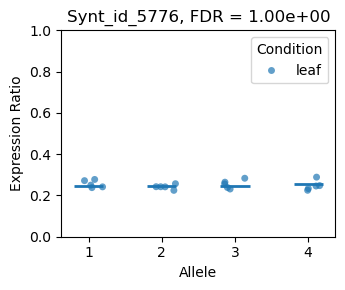

In [ ]:
# sort results by ratio_difference smallest first
results.sort_values(by='ratio_difference', ascending= True).groupby('Synt_id')

non_sig_results = results.sort_values(by='FDR', ascending= False).sort_values(by="Synt_id").head(16)

# 3. Plot the results
fig = plot_top_differential_syntelogs(results[results["Synt_id"] == "Synt_id_5776"], figsize=(6*3, 3))
plt.show()

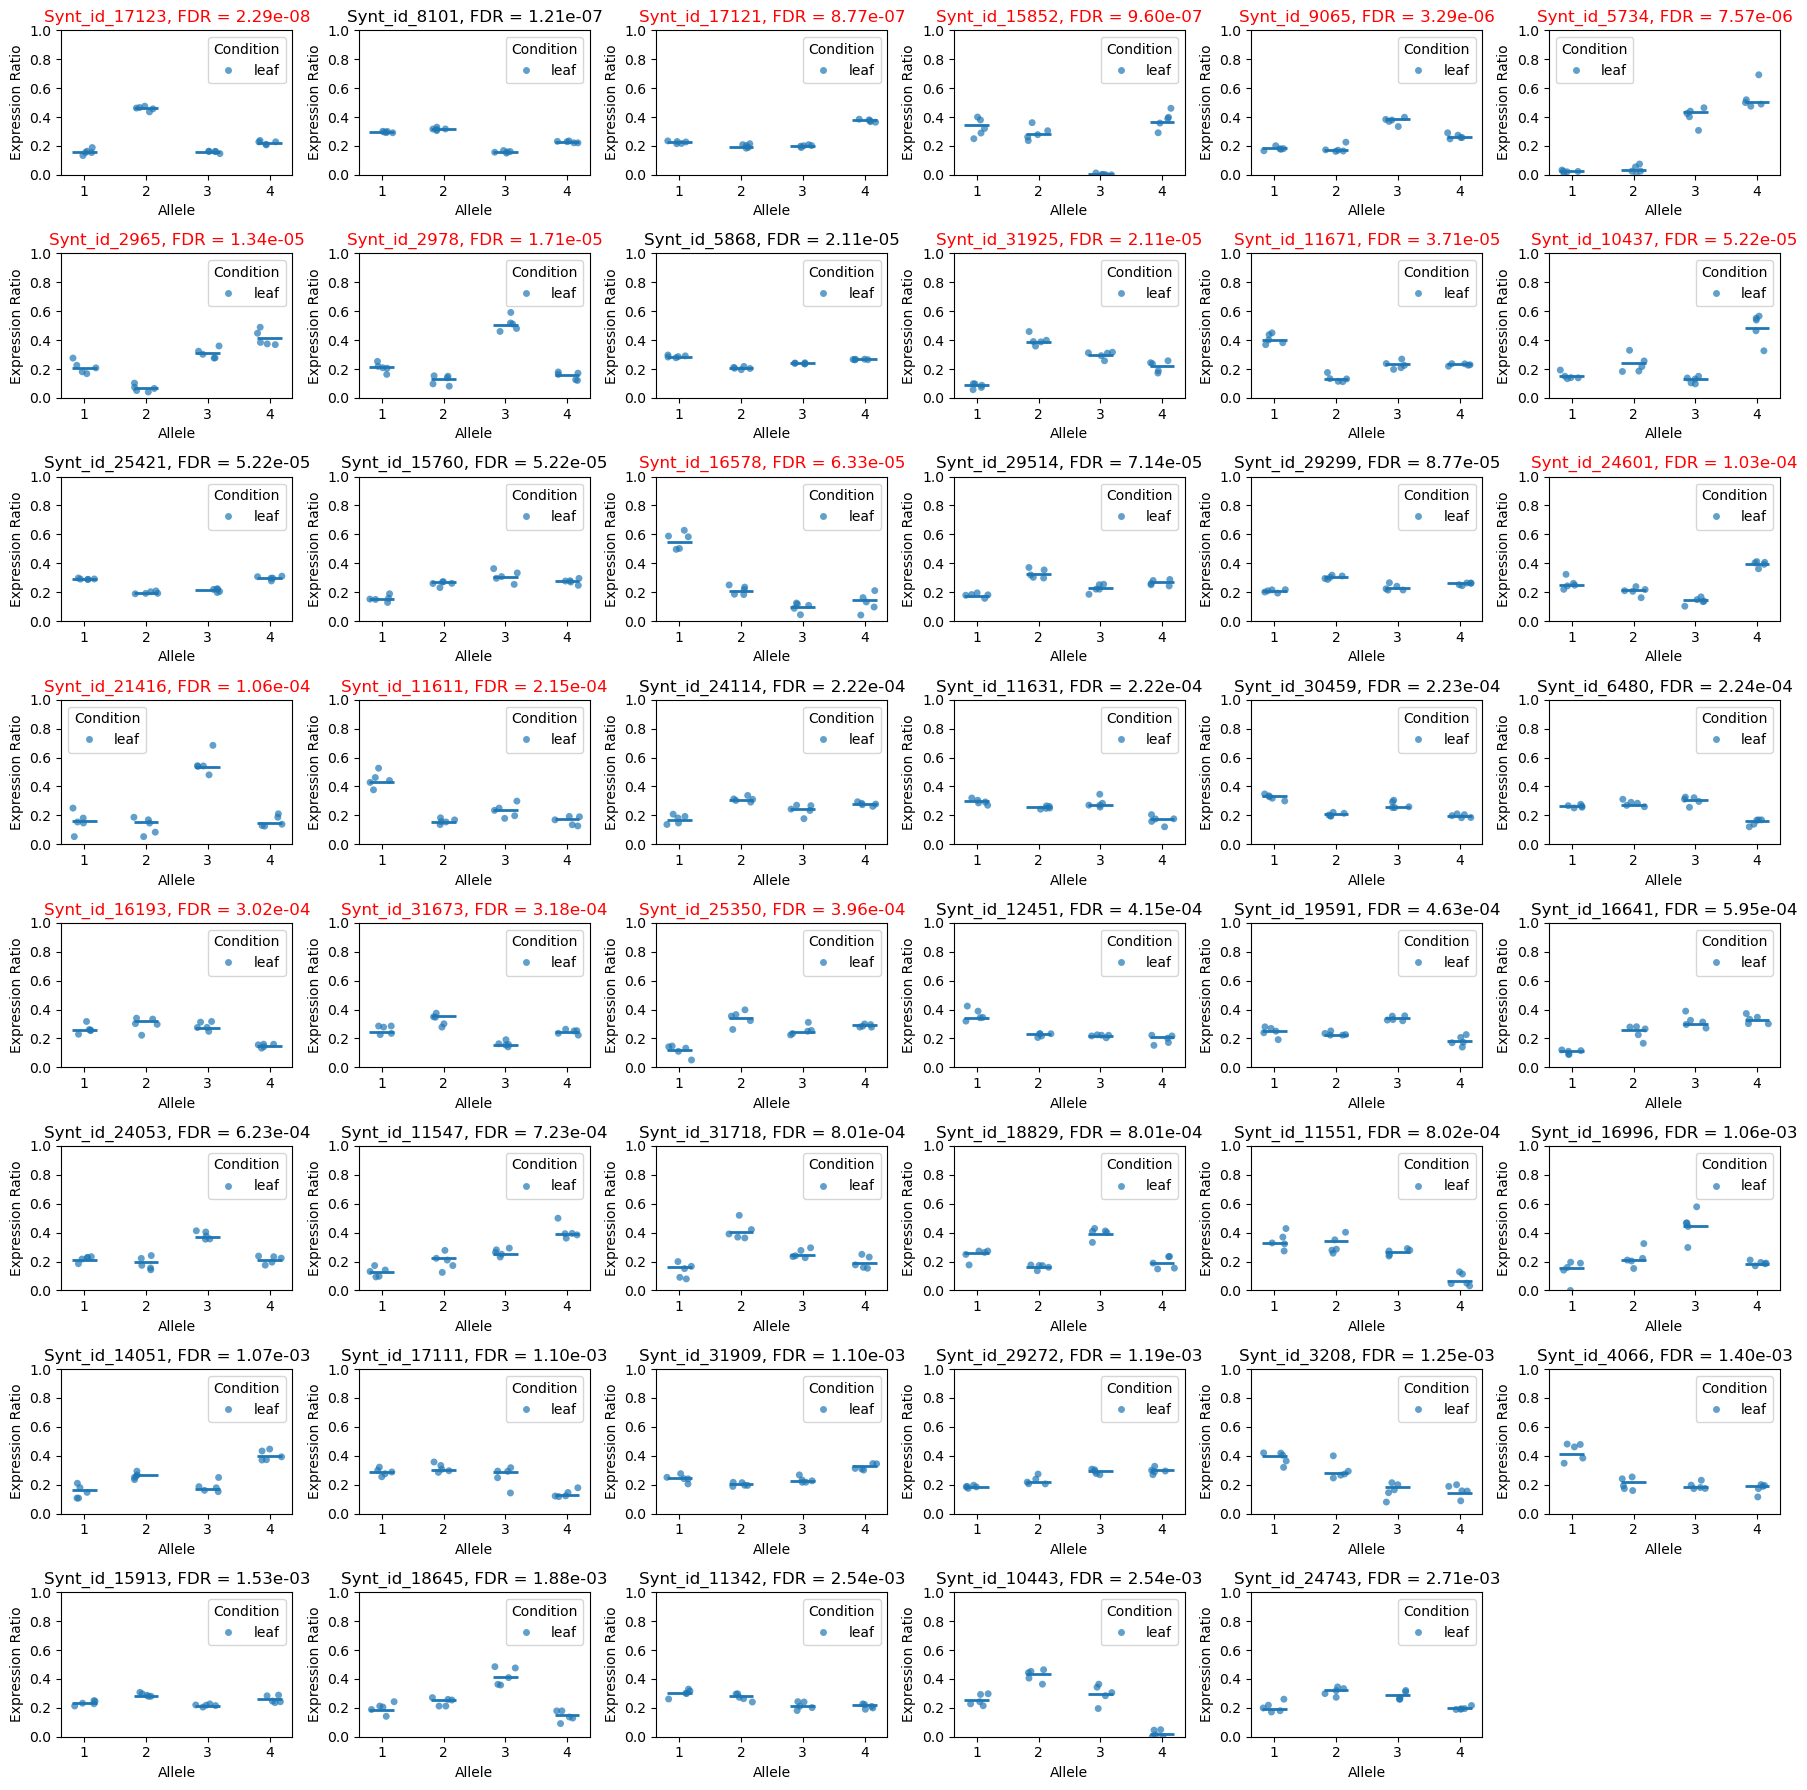

In [ ]:
# look at all
my_n = 47
fig = plot_top_differential_syntelogs(results, figsize=(18, 3*6), n = my_n, difference_threshold=0.1, sort_by='FDR', sig_threshold=0.0005)

# 4) Testing for differential allele usage between tuber and leave

Now we can also test if between the two conditions (tuber and leaf) the allelic expression changes. E.g is there a dominant allele in tuber that is not expressed in leaf?

In [ ]:
# Filter to only include synteny category "1hap1_1hap2_1hap3_1hap4_s" 

mask = (allelic_data.var["CDS_haplotype_with_longest_annotation"] == "equal_lengths" ) & (allelic_data.var["multimapping_ratio"] < 0.25) & (allelic_data.var["synteny_category"] == "1hap1_1hap2_1hap3_1hap4_s")
allelic_data_length_filter = allelic_data[:,mask].copy()

Why are we not filtering the allels with high multimapping ratios or unqual lengths?

Processing syntelog 100/217
Processing syntelog 200/217
Found 75 from 217 syntelogs with at least one significantly different allelic ratio (FDR < 0.05)


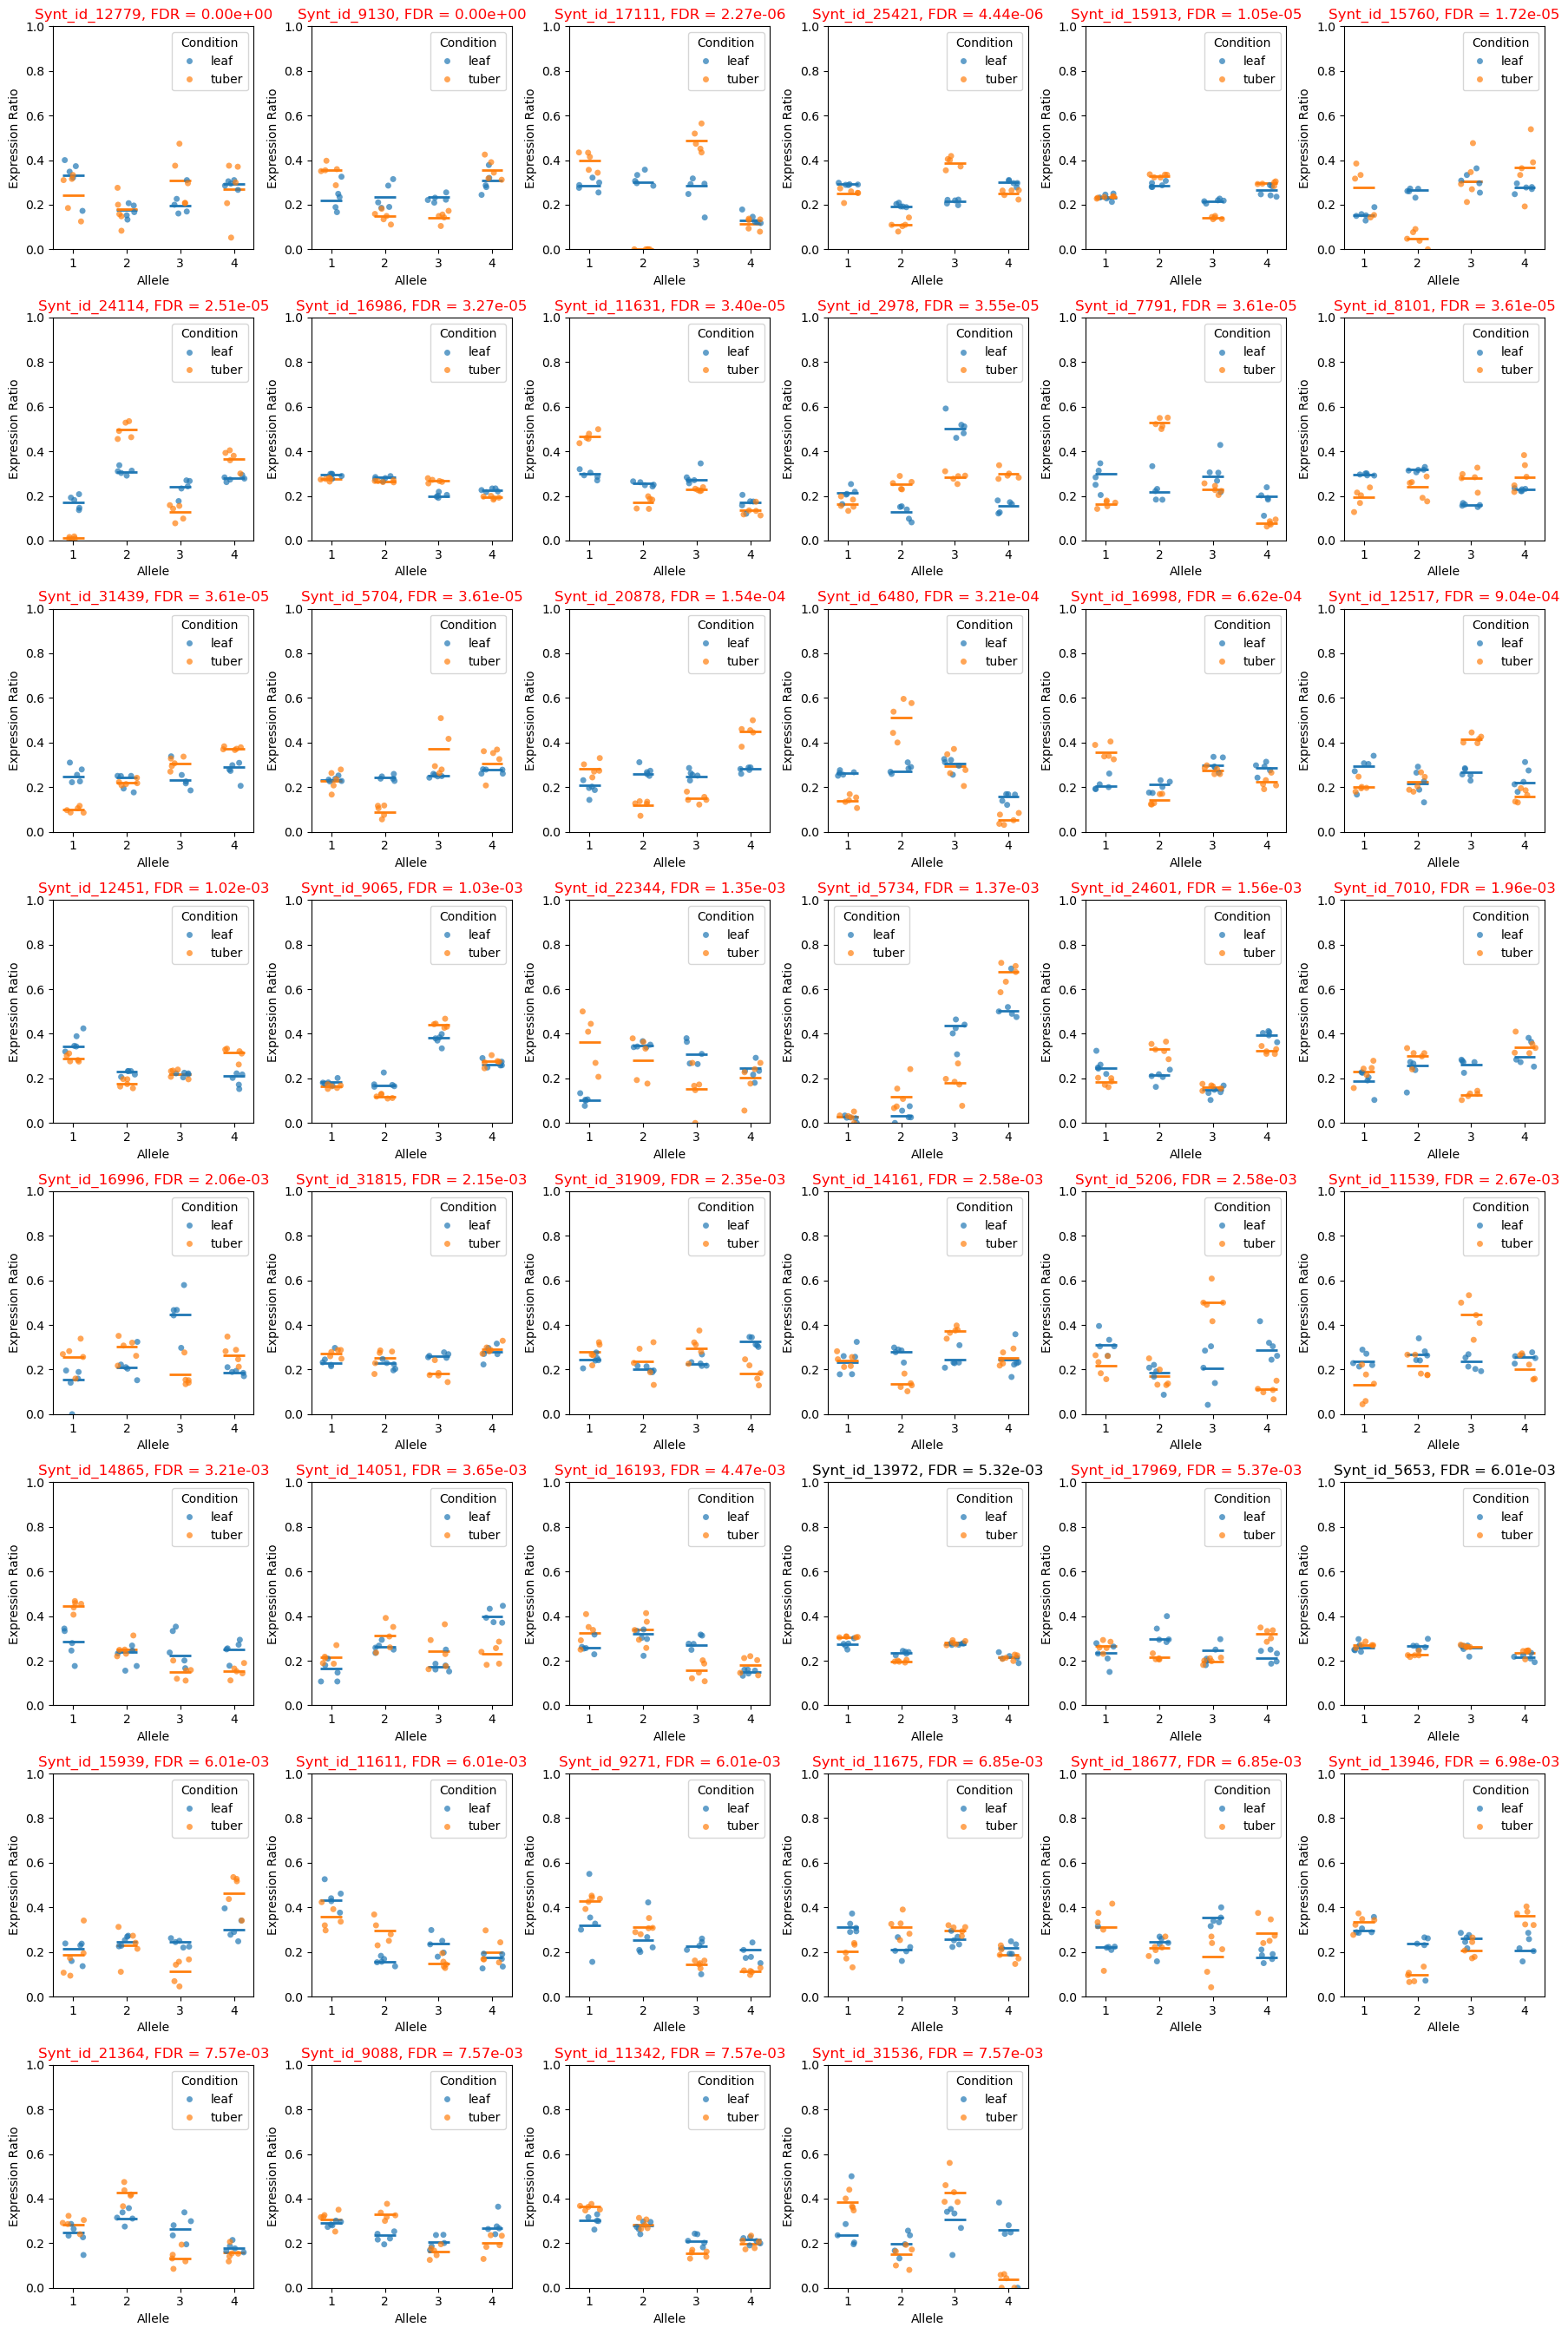

In [ ]:
# 1. Run allelic ratio test
results_df_trans = test_allelic_ratios_between_conditions(allelic_data_length_filter)

# 2. Get top differential syntelogs
top_results_trans = get_top_differential_syntelogs(results_df_trans, n=10, sort_by='FDR', fdr_threshold=0.05)

# 3. Plot the results
fig = plot_top_differential_syntelogs(results_df_trans,n = 46, figsize=(3*6, 3*9), sort_by='FDR')
plt.show()



https://spuddb.uga.edu/jb2/?session=share-3b8nGq87AT&password=R8aAc

In [ ]:
top_results_trans[top_results_trans["Synt_id"] == "Synt_id_31641"]

Synt_id allele               transcript_id       p_value  \
558  Synt_id_31641      2  Soltu.Atl_v3.12_2G022830.3  4.984393e-09   
557  Synt_id_31641      4  Soltu.Atl_v3.12_4G010920.1  9.283375e-09   
559  Synt_id_31641      1  Soltu.Atl_v3.12_1G007860.2  1.605588e-07   
560  Synt_id_31641      3  Soltu.Atl_v3.12_3G021510.8  2.196968e-01   

     ratio_difference  n_alleles  ratios_leaf_mean  \
558          0.277184          4          0.584637   
557          0.149927          4          0.206378   
559          0.114335          4          0.159575   
560          0.013557          4          0.050078   

                                       ratios_rep_leaf  ratios_tuber_mean  \
558  [0.5723502304147465, 0.5620689655172414, 0.571...           0.861821   
557  [0.20921658986175115, 0.21724137931034482, 0.2...           0.056451   
559  [0.1824884792626728, 0.1724137931034483, 0.139...           0.045240   
560  [0.035944700460829496, 0.04827586206896552, 0....           0.036521   

                                      ratios_rep_tuber       FDR  
558  [0.8341056533827618, 0.8583815028901735, 0.864...  0.000002  
557  [0.0685820203892493, 0.06502890173410404, 0.05...  0.000003  
559  [0.04819277108433735, 0.03757225433526012, 0.0...  0.000013  
560  [0.04911955514365153, 0.03901734104046243, 0.0...  0.468648

![image.png](attachment:image.png)

#https://spuddb.uga.edu/jb2/?session=local-7vzorxQDd9kfw8i1oFRMz

In [ ]:
# test quartinary plot
#%pip install python-quaternary
%pip install ternary

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# remove fig 
fig.clf()

In [ ]:
# group by Synt_id and make for each allele ratios_all mean column

results_melt = results.melt(id_vars=["Synt_id", "allele"], value_vars=["ratios_all_mean"]).sort_values(by=["Synt_id"])
# select the allele 1 
allele_1 = results_melt[results_melt["allele"] == "1"].copy()
allele_2 = results_melt[results_melt["allele"] == "2"].copy()
allele_3 = results_melt[results_melt["allele"] == "3"].copy()
allele_4 = results_melt[results_melt["allele"] == "4"].copy()


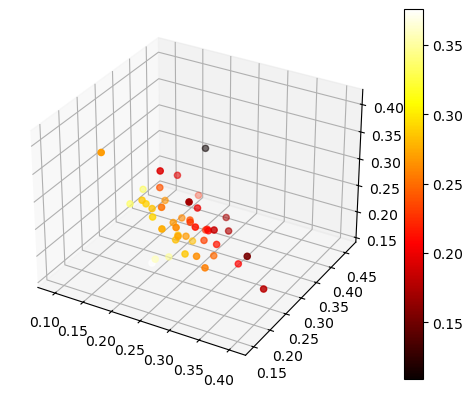

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = allele_1["value"]
y = allele_2["value"]
z = allele_3["value"]
c = allele_4["value"]


img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
fig.colorbar(img)
plt.show()

In [ ]:
import plotly.express as px

fig = px.scatter_ternary()
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
quat.plot(1, 2,3 )